# Covid Use Case Step 5 Result Analysis

In [1]:
import os
from pathlib import Path
import re

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nvita.attacks.utils import (append_result_to_csv_file,
                                 create_empty_result_csv_file)

d:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH_ROOT = Path(os.getcwd()).parent.absolute()
PATH_RESULT = os.path.join(PATH_ROOT, "examples", "covidusa_results")

In [3]:
def update_stat_dict(stat_dict, key):
    try:
        stat_dict[key] =  stat_dict[key] + 1
    except KeyError:
        stat_dict[key] = 1

def get_top_n_keys_and_vals_from_stat_dict(stat_dict, stat_name, n, total_number, round_int):
    all_ts =  ["day1", "day2", "day3", "day4", "day5", "day6", "day7"]
    all_fs =  ["new cases","new deaths","icu patients","hosp patients","new tests","new vaccinations","stringency index","population","gdp per"]

    stat_dict_keys = sorted(stat_dict, key=stat_dict.get, reverse=True)[:n]
    stat_dict_vals = []
    rank = 0

    top_k_keys = []
    top_k_pros = []
    for k in stat_dict_keys:
        rank += 1
        stat_dict_vals.append(stat_dict[k])
        if stat_name == "t":
            top_k_keys.append(all_ts[k])
            print("The top " + str(rank) + " attacked time is " + all_ts[k] + " with the attack probability of " + str(round(stat_dict[k]/total_number*100, round_int)) + "%")
        elif stat_name == "f":
            top_k_keys.append(all_fs[k])
            print("The top " + str(rank) + " attacked feature is " + all_fs[k] + " with the attack probability of " + str(round(stat_dict[k]/total_number*100, round_int)) + "%")
        elif stat_name == "fs":
            top_k_keys.append((all_fs[k[0]], str(k[1])))
            print("The top " + str(rank) + " attacked feature with sign is [" + all_fs[k[0]] + "," + str(k[1]) + "] with the attack probability of " + str(round(stat_dict[k]/total_number*100, round_int)) + "%")
        elif stat_name == "tf":
            top_k_keys.append((all_ts[k[0]], all_fs[k[1]]))
            print("The top " + str(rank) + " attacked time feature combination is [" + all_ts[k[0]] + "," + all_fs[k[1]] + "] with the attack probability of " + str(round(stat_dict[k]/total_number*100, round_int)) + "%")
        elif stat_name == "tfs":
            top_k_keys.append((all_ts[k[0]], all_fs[k[1]], str(k[2])))
            print("The top " + str(rank) + " attacked time feature combination with sign is [" + all_ts[k[0]] + "," + all_fs[k[1]] + "," + str(k[2]) + "] with the attack probability of " + str(round(stat_dict[k]/total_number*100, round_int)) + "%")
        top_k_pros.append(str(round(stat_dict[k]/total_number*100, round_int)))
    return top_k_keys, top_k_pros

In [4]:
def stat_report(df, n, attack_name, target, path_out_file):

    t_d, f_d, fs_d, tf_d, tfs_d = dict(), dict(), dict(), dict(), dict()

    print("There are "+str(len(df["Attack Stats"])) + " attacked windows")
    print("The average percentage change is " + str(round(sum(df["Percentage Changeed from the Attack"]/len(df["Percentage Changeed from the Attack"])),2))+"%")
    for attack_stat in df["Attack Stats"]:
        #print(attack_stat)
        tf_inds, tfs_inds = [], []
        count = 0
        attack_stat = re.sub(r"[^0-9.-]", ",", attack_stat)
        # Replace all non-numeric char with ","
        attack_stat_li = attack_stat.split(sep=",")
        inds = [None, None]
        # Time Feature Index
        indss = [None, None, None]
        # Time Feature Index with sign of perturbation
        for item in attack_stat_li:
            if item != "," and item != "":
                list_ind = count % 3

                if list_ind != 2:
                    inds[list_ind] = int(item)
                    indss[list_ind] = int(item)
                else:
                    indss[list_ind] = int(item)
                    tf_inds.append(inds)
                    tfs_inds.append(indss)

                    update_stat_dict(t_d, indss[0])
                    update_stat_dict(f_d, indss[1])
                    update_stat_dict(fs_d, (indss[1],indss[2]))
                    update_stat_dict(tf_d, tuple(inds))
                    update_stat_dict(tfs_d, tuple(indss))

                    inds = [None, None]
                    indss = [None, None, None]

                count += 1

        #print(tf_inds)
        #print(tfs_inds)

    round_int = 2
    get_top_n_keys_and_vals_from_stat_dict(t_d, "t", n,  len(df["Attack Stats"])*n, round_int)
    f_keys, f_pros = get_top_n_keys_and_vals_from_stat_dict(f_d, "f", n, len(df["Attack Stats"])*n, round_int)
    fs_keys, fs_pros = get_top_n_keys_and_vals_from_stat_dict(fs_d, "fs", n, len(df["Attack Stats"])*n, round_int)
    get_top_n_keys_and_vals_from_stat_dict(tf_d, "tf", n, len(df["Attack Stats"])*n, round_int)
    tfs_keys, tfs_pros = get_top_n_keys_and_vals_from_stat_dict(tfs_d, "tfs", n, len(df["Attack Stats"])*n, round_int)
    for rank in range(n):
        result = [attack_name, target, str(rank+1), f_keys[rank], f_pros[rank], str(list(fs_keys[rank])).replace(",", ";"), fs_pros[rank], str(list(tfs_keys[rank])).replace(",", ";"), tfs_pros[rank], tfs_keys[rank][-1]]
        append_result_to_csv_file(path_out_file, result)
    print('Save to:', path_out_file)
    print()

In [5]:
path_out_dir = os.path.join(PATH_ROOT, "examples", "covidusa_results")
path_out_file = os.path.join(path_out_dir, "CovidUSA_Stats_Report.csv")
first_result_line_list = ["Attack Name", "Target", "Rank", "Feature", "Feature P","Feature Sign", "Feature Sign P", "Time Feature Sign", "Time Feature Sign P", "Sign"]
create_empty_result_csv_file(path_out_file, first_result_line_list)
for n in [1,3,5]:
    attack_name = "Targeted_"+str(n)+"VITA"
    for target in ["Positive", "Negative"]:
        file_name = str("attack_"+attack_name+"_target_"+target+".csv")
        df = pd.read_csv(os.path.join(path_out_dir,  file_name))

        print("Start statistics report for " + file_name[:-4])
        
        stat_report(df, n, attack_name, target, path_out_file)
     

File c:\Users\markc\Working_Space\nvita\examples\covidusa_results\CovidUSA_Stats_Report.csv has already existed!
Start statistics report for attack_Targeted_1VITA_target_Positive
There are 70 attacked windows
The average percentage change is 4.27%
The top 1 attacked time is day1 with the attack probability of 40.0%
The top 1 attacked feature is new vaccinations with the attack probability of 41.43%
The top 1 attacked feature with sign is [new vaccinations,-1] with the attack probability of 31.43%
The top 1 attacked time feature combination is [day1,icu patients] with the attack probability of 27.14%
The top 1 attacked time feature combination with sign is [day1,icu patients,-1] with the attack probability of 27.14%
Save to: c:\Users\markc\Working_Space\nvita\examples\covidusa_results\CovidUSA_Stats_Report.csv

Start statistics report for attack_Targeted_1VITA_target_Negative
There are 70 attacked windows
The average percentage change is -4.33%
The top 1 attacked time is day1 with the a

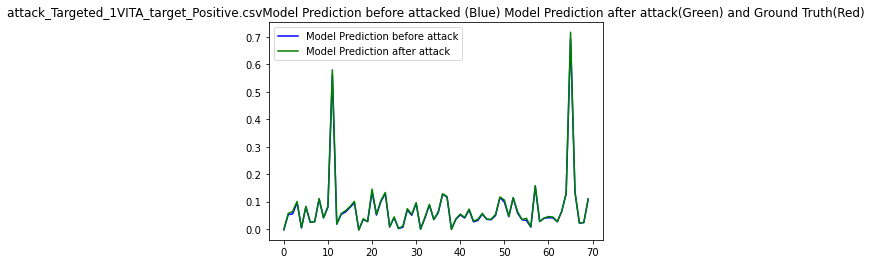

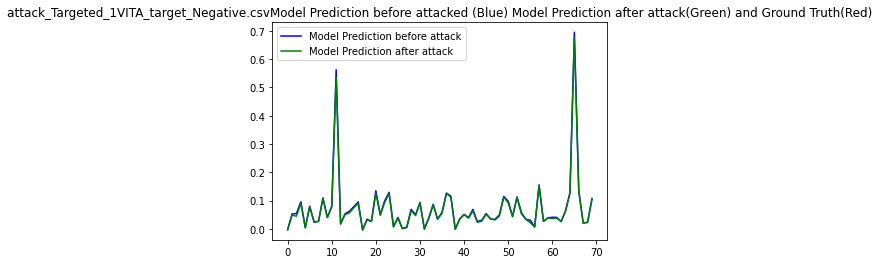

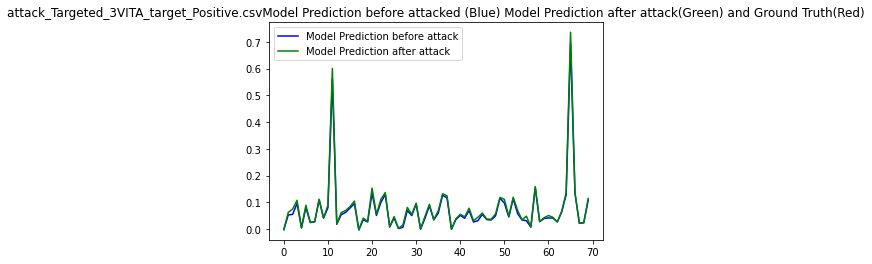

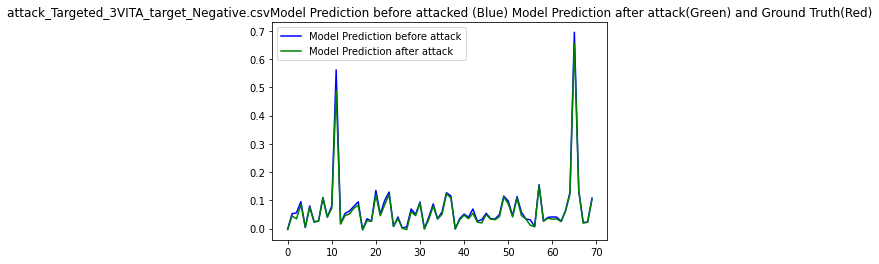

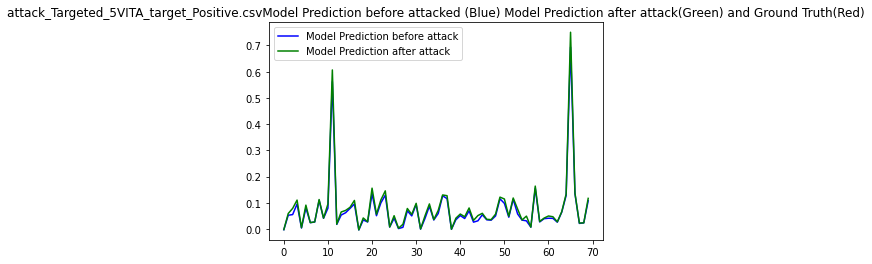

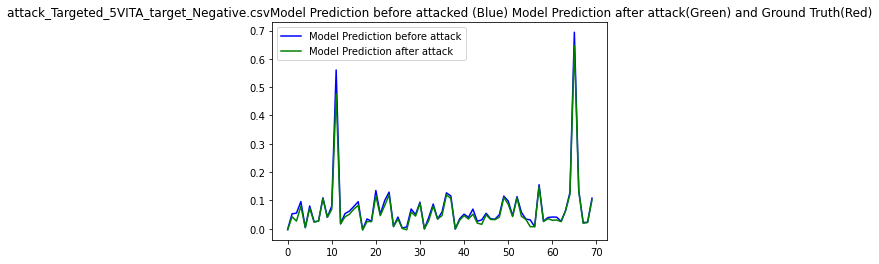

In [6]:
# Visulaize the model prediction
path_out_dir = os.path.join(PATH_ROOT, "examples", "covidusa_results")
for n in [1,3,5]:
    attack_name = "Targeted_"+str(n)+"VITA"
    for target in ["Positive", "Negative"]:
        file_name = str("attack_"+attack_name+"_target_"+target+".csv")
        df = pd.read_csv(os.path.join(path_out_dir,  file_name))
        #plt.plot(df["True y"], color = "Red", label="Ground truth")
        plt.plot(df["Original y Pred"], color = "Blue", label="Model Prediction before attack")
        plt.plot(df["Attacked y Pred"], color = "Green", label="Model Prediction after attack")
        plt.title(file_name + "Model Prediction before attacked (Blue) Model Prediction after attack(Green) and Ground Truth(Red)")
        plt.legend()
        plt.show()

In [47]:
stats_df = pd.read_csv(os.path.join(path_out_file)).iloc[:, :-1] # Drop the last unname column
#stats_df["Target Rank"] = stats_df["Target"] + " " + stats_df["Rank"].astype(str)
#stats_df["Target Feature"] = stats_df["Target"] + " " + stats_df["Feature"]
stats_1_df = stats_df[stats_df["Attack Name"] == "Targeted_1VITA"]
stats_3_df = stats_df[stats_df["Attack Name"] == "Targeted_3VITA"]
stats_5_df = stats_df[stats_df["Attack Name"] == "Targeted_5VITA"]

tf_li = []
for s in stats_df["Time Feature Sign"]:
    s_li = s.split(";")
    out = s_li[1][2:-1].title() + " (" + s_li[0][2:-1].title() + ")"
    if out[:3] == "Icu":
        out = out[:3].upper() + out[3:]
    out = out.replace("Vaccinations", "Vacci")
    tf_li.append(out)

stats_df["Time Feature"] = tf_li
pd.unique(stats_df["Time Feature"])

array(['ICU Patients (Day1)', 'New Vacci (Day1)', 'New Vacci (Day7)',
       'ICU Patients (Day7)', 'New Vacci (Day3)', 'ICU Patients (Day2)'],
      dtype=object)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


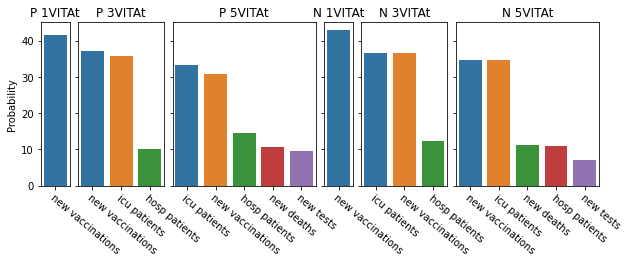

In [8]:
f, ax = plt.subplots(1, 6, figsize=(10, 3), gridspec_kw={'width_ratios': [1, 3, 5, 1, 3, 5]}, sharey=True, sharex=False)
for j, att_dire in enumerate(stats_df["Target"].unique()):
    df =  stats_df[stats_df["Target"] == att_dire]
    for i,att_name in enumerate(stats_df["Attack Name"].unique()):
        g = sns.barplot(ax=ax[j*3+i], errwidth=1.5, data=df[df["Attack Name"] == att_name], y="Feature P", x="Feature")
        #g = sns.scatterplot(palette=cdict_t, hue_order=order_t[3:], alpha=0.9, s=80, ax=ax[i],
                            #data=df_t_attacks_anns_grouped.reset_index()[df_t_attacks_anns_grouped.reset_index().Epsilon == eps], 
                            #hue="Attack Name", y="Attacked AE", x="Sum Per", style="Attack Name", legend=i==3)
        g.set_title(att_dire[0] + " " + str(1+i*2) + "VITAt")
        g.set_xlabel("")
        if j*3+i==0: g.set_ylabel("Probability")
        else: g.set_ylabel("")
        g.set_xticklabels(g.get_xticklabels(), rotation = 320, ha="left", rotation_mode="anchor")
plt.legend(loc="lower left", bbox_to_anchor=(1.01, 0), frameon=False, ncol=1)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.25)
#plt.savefig("t_tradeoff_smaller.pdf", bbox_inches="tight")



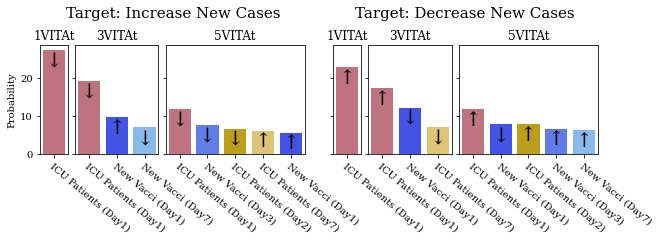

In [48]:
from matplotlib import colors

plt.rc("font", family="serif")
cmap = colors.LinearSegmentedColormap.from_list("", ["lightskyblue","blue"])

# cdict_tfs = {"ICU Patients (Day1)":"#CC6677", 
#             "New Vaccinations (Day1)":cmap(0.70),
#             "New Vaccinations (Day7)":cmap(0.1), 
#             "ICU Patients (Day7)":"#EECC66",
#             "New Vaccinations (Day3)": cmap(0.45), 
#             "ICU Patients (Day2)":"#d7af00"}

cdict_tfs = {"ICU Patients (Day1)":"#CC6677", 
            "New Vacci (Day1)":cmap(0.70),
            "New Vacci (Day7)":cmap(0.1), 
            "ICU Patients (Day7)":"#EECC66",
            "New Vacci (Day3)": cmap(0.45), 
            "ICU Patients (Day2)":"#d7af00"}
            
f, ax = plt.subplots(1, 7, figsize=(10, 2), gridspec_kw={'width_ratios': [1, 3, 5, 0.5, 1, 3, 5]}, sharey=True, sharex=False)
first = True
for j, att_dire in enumerate(stats_df["Target"].unique()):
    df =  stats_df[stats_df["Target"] == att_dire]
    for i,att_name in enumerate(stats_df["Attack Name"].unique()):
        if first == False:
            g = sns.barplot(palette=cdict_tfs, ax=ax[j*3+i+1], errwidth=1.5, data=df[df["Attack Name"] == att_name], y="Time Feature Sign P", x="Time Feature")
        else:
            g = sns.barplot(palette=cdict_tfs, ax=ax[j*3+i], errwidth=1.5, data=df[df["Attack Name"] == att_name], y="Time Feature Sign P", x="Time Feature")
        g.set_title(str(1+i*2) + "VITAt")
        g.set_xlabel("")
        y_lim = g.get_ylim()
        if j*3+i==0: g.set_ylabel("Probability")
        else: g.set_ylabel("")
        g.set_xticklabels(g.get_xticklabels(), rotation = 320, ha="left", rotation_mode="anchor")

        if j*3+i==0: g.text(-0.3,23, "↓", fontsize=20)
        if j*3+i==1: 
            g.text(-0.3,15, "↓", fontsize=20)
            g.text(0.70,5.5, "↑", fontsize=20)
            g.text(1.70,2.5, "↓", fontsize=20)
        if j*3+i==2: 
            g.text(-0.3,7.5, "↓", fontsize=20)
            g.text(0.70,3.5, "↓", fontsize=20)
            g.text(1.70,2.5, "↓", fontsize=20)
            g.text(2.70,2, "↑", fontsize=20)
            g.text(3.70,1.5, "↑", fontsize=20)
        if j*3+i==3: g.text(-0.3,18.5, "↑", fontsize=20)
        if j*3+i==4: 
            g.text(-0.3,13, "↑", fontsize=20)
            g.text(0.70,8, "↓", fontsize=20)
            g.text(1.70,3, "↓", fontsize=20)
        if j*3+i==5: 
            g.text(-0.3,7.5, "↑", fontsize=20)
            g.text(0.70,3.5, "↓", fontsize=20)
            g.text(1.70,3.5, "↑", fontsize=20)
            g.text(2.70,2.5, "↑", fontsize=20)
            g.text(3.70,2, "↑", fontsize=20)
    ax[3].set_visible(False)
    first = False

plt.figtext(0.31,1.1,"Target: Increase New Cases", va="center", ha="center", size=15)
plt.figtext(0.715,1.1,"Target: Decrease New Cases", va="center", ha="center", size=15)
#plt.legend(loc="lower left", bbox_to_anchor=(1.01, 0), frameon=False, ncol=1)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.25)
plt.savefig("t_covid_use_case_result.pdf", bbox_inches="tight")